In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
from sklearn.datasets import fetch_olivetti_faces
from gpzoo.kernels import NSF_RBF
from gpzoo.gp import NSF

In [2]:
new_model=False

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
data, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=97)

In [5]:
Y = (data)*255
Y = Y.astype(int)
Y = torch.tensor(Y)

In [6]:
idx = torch.linspace(-32, 32, 64, dtype=torch.float)
X = torch.cartesian_prod(-idx, idx).flip(dims=[1])
N = X.shape[0]

In [7]:
L =10
M = 32*32
kernel = NSF_RBF(L=L, lengthscale=2)
model = NSF(X=X, y=Y, kernel=kernel, M=M, L=L, jitter=1e-2)
idz = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
model.svgp.Z = nn.Parameter(X[idz])

if not new_model:
    model.load_state_dict(torch.load('eigenfaces_nsf', map_location=device))
    
model.to(device)

NSF(
  (kernel): NSF_RBF()
  (svgp): SVGP(
    (kernel): NSF_RBF()
  )
)

In [8]:
X_train = X.to(device)
Y_train = Y.to(device)

In [9]:
def train(model, optimizer, X, y, steps=200, E=20):
    losses = []
    for it in tqdm(range(steps)):

        optimizer.zero_grad()
        pY, qF, qU, pU = model(X, E=E)


        ELBO = (pY.log_prob(y)).mean(axis=0).sum()

        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))


        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    return losses

# Train until convergence

In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
losses = train(model, optimizer, X_train, Y_train, steps=100)

  0%|          | 0/100 [00:00<?, ?it/s]

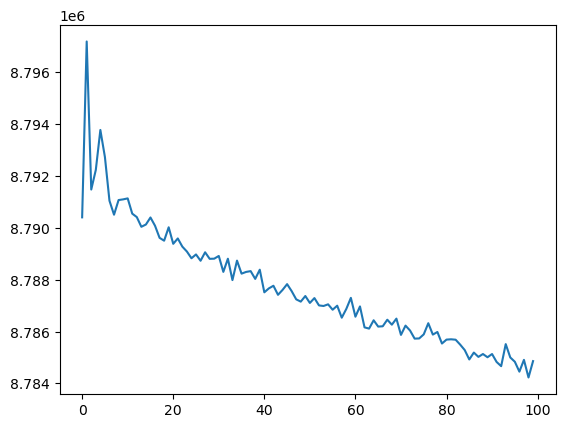

In [17]:
plt.plot(losses)

In [13]:
pY, qF, qU, pU = model(X_train, E=1)

# Visualize Factors

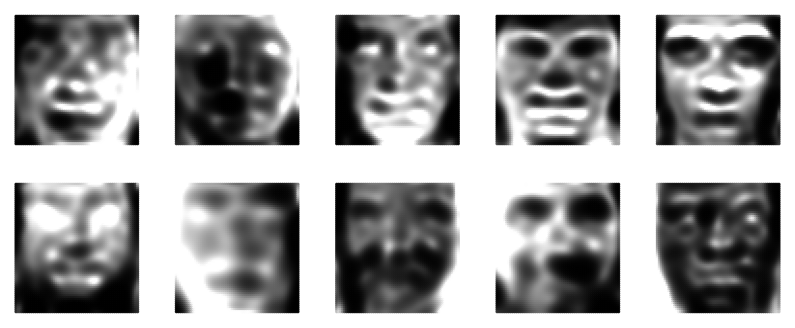

In [14]:
plt.figure(figsize=(10, L*2//5))
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    loading = torch.exp(qF.mean[i]).detach().cpu().numpy()
    plt.scatter(X[:, 0], X[:,1], c=loading, cmap='gray',  vmin=0, vmax=10, alpha=0.9, s=2)

    plt.axis('off')

# Visualize Inducing points

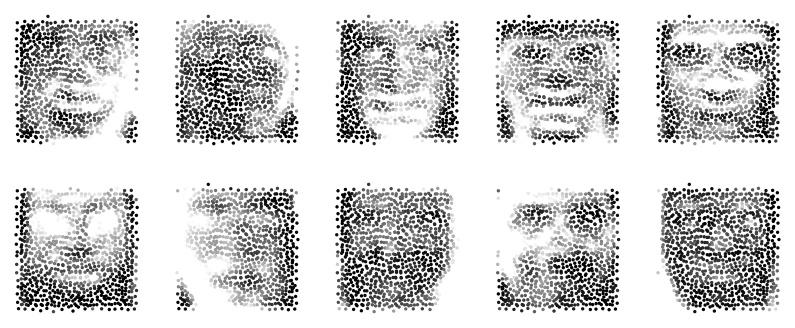

In [15]:
Z = model.svgp.Z.detach().cpu().numpy()

plt.figure(figsize=(10, L*2//5))
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    loading = torch.exp(qU.mean[i]).detach().cpu().numpy()
    
    plt.scatter(Z[:,0], Z[:,1], c=loading, cmap='gray',  vmin=0, vmax=10,  s=2)

    plt.axis('off')

In [16]:
torch.save(model.state_dict(), 'eigenfaces_nsf') 